This report deals with a sample sequential data analisys and is written for the second assignment under the Intelligent Systems course at FRI UNI LJ.


In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Preprocessing

The `load_and_transform` method was implemented in order to:

1. Load data from a `.tsv` file.
2. Extract some basic features (the ones that must be extracted before preprocessing).
3. Preprocess text. This incudes:
    - conversion to lowercase text,
    - URL removal,
    - removal of all non-ASCII chars,
    - removal of stopwords,
    - word stemming,
    - stripping of any redundant whitespaces.

The method is used to load both train and test data.
    

In [2]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize


def load_and_transform(table_name):
    df = pd.read_table(table_name)

    # Extract some basic features.
    df['word_count'] = df['text_a'].apply(lambda x: len(str(x).split(' ')))
    df['char_count'] = df['text_a'].apply(lambda x: len(x))
    df['hashtag_count'] = df['text_a'].apply(lambda x: x.count('#'))
    df['https_link_count'] = df['text_a'].apply(lambda x: x.count('https://'))
    df['http_link_count'] = df['text_a'].apply(lambda x: x.count('http://'))
    df['number_of_nums'] = df['text_a'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    df['number_of_non_ascii'] = df['text_a'].apply(lambda x: len(x) - len([i for i in x if ord(i) < 256]))

    # Convert to lower case.
    df['text_a'] = df['text_a'].apply(lambda x: x.lower())

    # Remove urls.
    remove_urls = lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', x)
    df['text_a'] = df['text_a'].apply(remove_urls)

    # Remove non alpha and not ascii chars.
    remove_non_alpha = lambda x: ''.join([i for i in x if (i.isalpha() and ord(i) < 256) or i == ' '])
    df['text_a'] = df['text_a'].apply(remove_non_alpha)

    # Remove stopwords.
    ENGLISH_STOPWORDS = set(stopwords.words('english'))
    remove_stopwords = lambda x: ' '.join([w for w in x.split() if w not in ENGLISH_STOPWORDS])
    df['text_a'] = df['text_a'].apply(remove_stopwords)

    # Stem words.
    stemmer = SnowballStemmer('english')
    stem_words = lambda x: ' '.join(stemmer.stem(token) for token in word_tokenize(x))
    df['text_a'] = df['text_a'].apply(stem_words)

    # Strip.
    df['text_a'] = df['text_a'].apply(lambda x: (' '.join(x.split())).strip())
    return df

# Feature construction

3 different kinds of input data sets were constructed:

1. TFIDF (term frequency–inverse document frequency).
2. Contextual data, which includes:
    - word count,
    - character count,
    - hashtag (`#`) count,
    - https link count,
    - http link count,
    - number of numbers and
    - number of non-ascii characters.
3. A matrix that includes both types defined above.


The input data types were constructed to compare complex models to models, derived from some basic (easily computed) features.

The following methods extract this data.


In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import re


def get_tfidf_features(df, show_plots=False):
    def avg_word_len(x):
        word_lens = [len(i) for i in x.split()]
        return sum(word_lens) / len(word_lens)

    df['avg_word_len'] = df['text_a'].apply(avg_word_len)

    # Bag of words.
    vec = CountVectorizer(max_features=1000, min_df=5, max_df=0.85, ngram_range=(1, 2), analyzer='word')
    X = vec.fit_transform(df['text_a']).toarray()

    if show_plots:
        td_matrix = pd.DataFrame(X, columns=vec.get_feature_names_out())
        td_matrix = td_matrix.T
        td_matrix['total_count'] = td_matrix.sum(axis=1)
        td_matrix = td_matrix.sort_values(by='total_count', ascending=False)[:35]
        td_matrix['total_count'].plot.bar()
        plt.show()

    # TFIDF
    tfidfconverter = TfidfTransformer()
    X = tfidfconverter.fit_transform(X).toarray()
    return X


def get_contextual_features(df):
    return df[[
        'word_count',
        'char_count',
        'hashtag_count',
        'http_link_count',
        'http_link_count',
        'number_of_nums',
        'number_of_non_ascii',
        'avg_word_len',
    ]].to_numpy()


Train and test data is then loaded. Features are computed once in advance and used multiple times for different models.

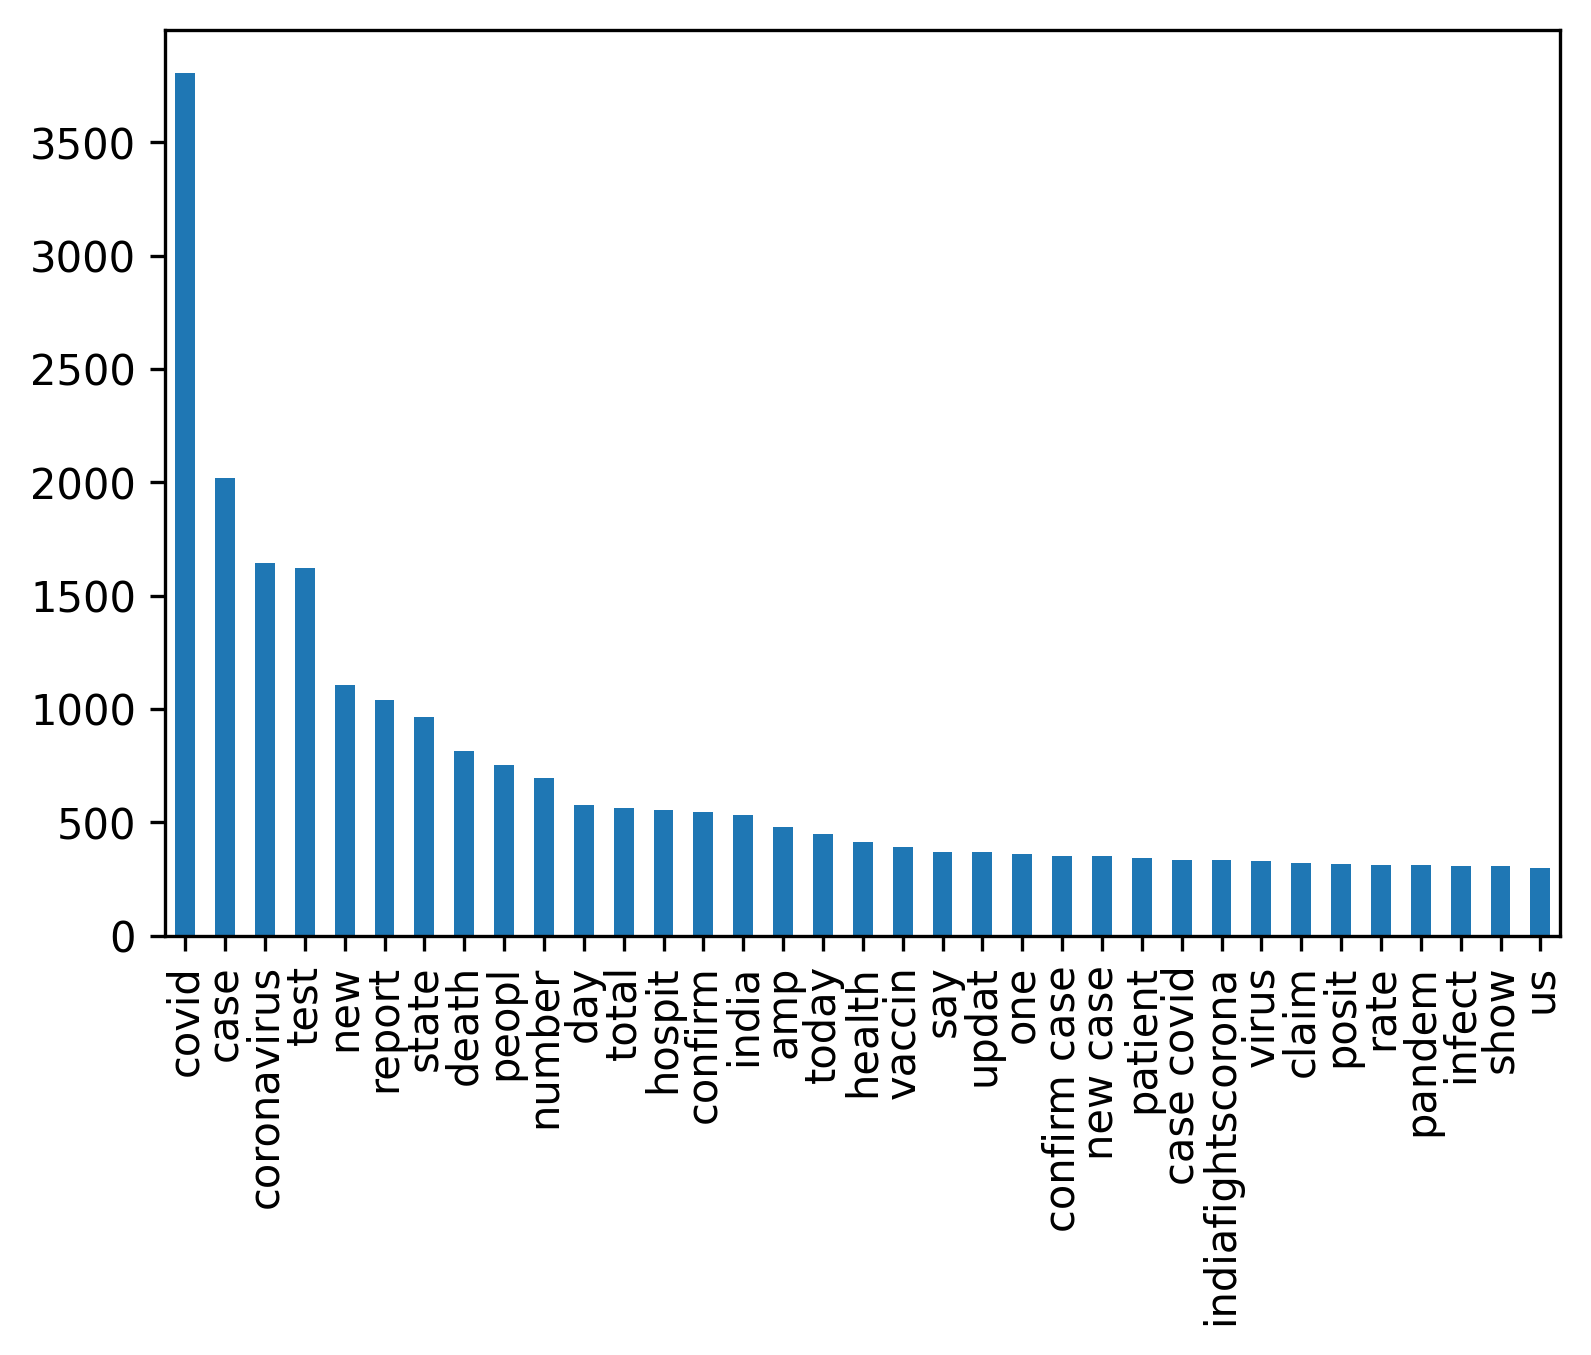

In [4]:
# Load data.
train = load_and_transform('data/train_data.tsv')
x_train_tfidf = get_tfidf_features(train, show_plots=True)
x_train_context = get_contextual_features(train)
x_train = np.hstack((x_train_tfidf, x_train_context))
y_train = train['label']

test = load_and_transform('data/test_data.tsv')
x_test_tfidf = get_tfidf_features(test)
x_test_context = get_contextual_features(test)
x_test = np.hstack((x_test_tfidf, x_test_context))
y_test = test['label']

As expected, the input data contains a lot of words regarding COVID-19 pandemic. There are also a lot of words without meaning, but those are not very frequent.

# Modeling

Method for model evaluation was implemented in order to simplify the model construction section.

In [5]:
from sklearn.metrics import accuracy_score, f1_score

scores = []

def evaluate_model(model, x_test_against):
    global scores
    y_pred = model.predict(x_test_against)
    a = accuracy_score(y_test, y_pred)
    scores.append(a)
    return 'Accuracy: {:.3f}\t\tF1: {:.3f}'.format(a, f1_score(y_test, y_pred))


Construction and evaluation of each separate model was then performed. Each model's hyperparameters were configured to reach roughly the best possible target using this method.

In [6]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Works the same regardless of features.
print('========== MAJORITY ==========')
majority_classifier = DummyClassifier()
majority_classifier.fit(x_train_tfidf, y_train)
print(evaluate_model(majority_classifier, x_test_tfidf))

print('========== Knn (tfidf) ==========')
knn_classifier_tfidf = KNeighborsClassifier(n_neighbors=100, metric='minkowski')
knn_classifier_tfidf.fit(x_train_tfidf, y_train)
print(evaluate_model(knn_classifier_tfidf, x_test_tfidf))

print('========== Knn (context) ==========')
knn_classifier_context = KNeighborsClassifier(n_neighbors=3, metric='minkowski')
knn_classifier_context.fit(x_train_context, y_train)
print(evaluate_model(knn_classifier_context, x_test_context))

print('========== SVM linear (tfidf) ==========')
svm_linear_classifier_tfidf = SVC(kernel='linear')
svm_linear_classifier_tfidf.fit(x_train_tfidf, y_train)
print(evaluate_model(svm_linear_classifier_tfidf, x_test_tfidf))

print('========== SVM linear (context) ==========')
svm_linear_classifier_context = SVC(kernel='linear')
svm_linear_classifier_context.fit(x_train_context, y_train)
print(evaluate_model(svm_linear_classifier_context, x_test_context))

print('========== SVM linear (all) ==========')
svm_linear_classifier_all = SVC(kernel='linear')
svm_linear_classifier_all.fit(x_train, y_train)
print(evaluate_model(svm_linear_classifier_all, x_test))

print('========== SVM poly (tfidf) ==========')
svm_poly_classifier_tfidf = SVC(kernel='poly')
svm_poly_classifier_tfidf.fit(x_train_tfidf, y_train)
print(evaluate_model(svm_poly_classifier_tfidf, x_test_tfidf))

print('========== SVM poly (context) ==========')
svm_poly_classifier_context = SVC(kernel='poly')
svm_poly_classifier_context.fit(x_train_context, y_train)
print(evaluate_model(svm_poly_classifier_context, x_test_context))

print('========== SVM poly (all) ==========')
svm_poly_classifier_all = SVC(kernel='poly')
svm_poly_classifier_all.fit(x_train, y_train)
print(evaluate_model(svm_poly_classifier_all, x_test))

print('========== RANDOM FOREST (tfidf) ==========')
rf_classifier_tfidf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_classifier_tfidf.fit(x_train_tfidf, y_train)
print(evaluate_model(rf_classifier_tfidf, x_test_tfidf))

print('========== RANDOM FOREST (context) ==========')
rf_classifier_context = RandomForestClassifier(n_estimators=30, random_state=0)
rf_classifier_context.fit(x_train_context, y_train)
print(evaluate_model(rf_classifier_context, x_test_context))

print('========== RANDOM FOREST (all) ==========')
rf_classifier_all = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_classifier_all.fit(x_train, y_train)
print(evaluate_model(rf_classifier_all, x_test))

print('========== GRADIENT BOOSTING (tfidf) ==========')
gb_classifier_tfidf = GradientBoostingClassifier(n_estimators=1000)
gb_classifier_tfidf.fit(x_train_tfidf, y_train)
print(evaluate_model(gb_classifier_tfidf, x_test_tfidf))

print('========== GRADIENT BOOSTING (context) ==========')
gb_classifier_context = GradientBoostingClassifier(n_estimators=30)
gb_classifier_context.fit(x_train_context, y_train)
print(evaluate_model(gb_classifier_context, x_test_context))

print('========== GRADIENT BOOSTING (all) ==========')
gb_classifier_all = GradientBoostingClassifier(n_estimators=1000)
gb_classifier_all.fit(x_train, y_train)
print(evaluate_model(gb_classifier_all, x_test))

print('========== XGBoost (tfidf) ==========')
xgb_classifier_tfidf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier_tfidf.fit(x_train_tfidf, y_train)
print(evaluate_model(xgb_classifier_tfidf, x_test_tfidf))

print('========== XGBoost (context) ==========')
xgb_classifier_context = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier_context.fit(x_train_context, y_train)
print(evaluate_model(xgb_classifier_context, x_test_context))

print('========== XGBoost (all) ==========')
xgb_classifier_all = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier_all.fit(x_train, y_train)
print(evaluate_model(xgb_classifier_all, x_test))

========== MAJORITY ==========
Accuracy: 0.523		F1: 0.687
========== Knn (tfidf) ==========
Accuracy: 0.568		F1: 0.540
========== Knn (context) ==========
Accuracy: 0.745		F1: 0.762
========== SVM linear (tfidf) ==========
Accuracy: 0.634		F1: 0.638
========== SVM linear (context) ==========
Accuracy: 0.741		F1: 0.746
========== SVM linear (all) ==========
Accuracy: 0.676		F1: 0.687
========== SVM poly (tfidf) ==========
Accuracy: 0.589		F1: 0.577
========== SVM poly (context) ==========
Accuracy: 0.523		F1: 0.687
========== SVM poly (all) ==========
Accuracy: 0.523		F1: 0.687
========== RANDOM FOREST (tfidf) ==========
Accuracy: 0.663		F1: 0.607
========== RANDOM FOREST (context) ==========
Accuracy: 0.806		F1: 0.817
========== RANDOM FOREST (all) ==========
Accuracy: 0.778		F1: 0.773
========== GRADIENT BOOSTING (tfidf) ==========
Accuracy: 0.638		F1: 0.599
========== GRADIENT BOOSTING (context) ==========
Accuracy: 0.787		F1: 0.799
========== GRADIENT BOOSTING (all) ==========
Accur

To enable a majority voting ensable for models using different input vectors, a simple class was implemented. It feeds input data of the right type into all the classifiers from the previous section and then returns the majority value.

This did not provide any better results but was an interesting exercise nonetheless.

In [7]:
class CustomVotingClassifier:
    def __init__(self, tfidf_classifiers, context_classifiers, all_classifiers):
        self.tfidf_classifiers = tfidf_classifiers
        self.context_classifiers = context_classifiers
        self.all_classifiers = all_classifiers
        self.len = len(tfidf_classifiers) + len(context_classifiers) + len(all_classifiers)

    def predict(self, X):
        res = np.zeros(X.shape[0])
        for c in self.tfidf_classifiers:
            y_pred = c.predict(x_test_tfidf)
            res = np.add(res, y_pred)

        for c in self.context_classifiers:
            y_pred = c.predict(x_test_context)
            res = np.add(res, y_pred)

        for c in self.all_classifiers:
            y_pred = c.predict(x_test)
            res = np.add(res, y_pred)

        def vote(x):
            a = x / self.len
            return 0 if a < 0.5 else 1

        vf = np.vectorize(vote)
        return vf(res)


print('========== Custom voting ==========')
custom_voting_classifier = CustomVotingClassifier(
    [knn_classifier_tfidf, svm_linear_classifier_tfidf, svm_poly_classifier_tfidf, rf_classifier_tfidf,
     xgb_classifier_tfidf, gb_classifier_tfidf],
    [knn_classifier_context, svm_linear_classifier_context, svm_poly_classifier_context, rf_classifier_context,
     xgb_classifier_context, gb_classifier_context],
    [svm_linear_classifier_all, svm_poly_classifier_all, rf_classifier_all, xgb_classifier_all, gb_classifier_all]
)
print(evaluate_model(custom_voting_classifier, x_test_context))


========== Custom voting ==========
Accuracy: 0.787		F1: 0.799


As expected, custom voting does not in any way improve on the best classifiers from previous sections.

# Evaluation

<BarContainer object of 19 artists>

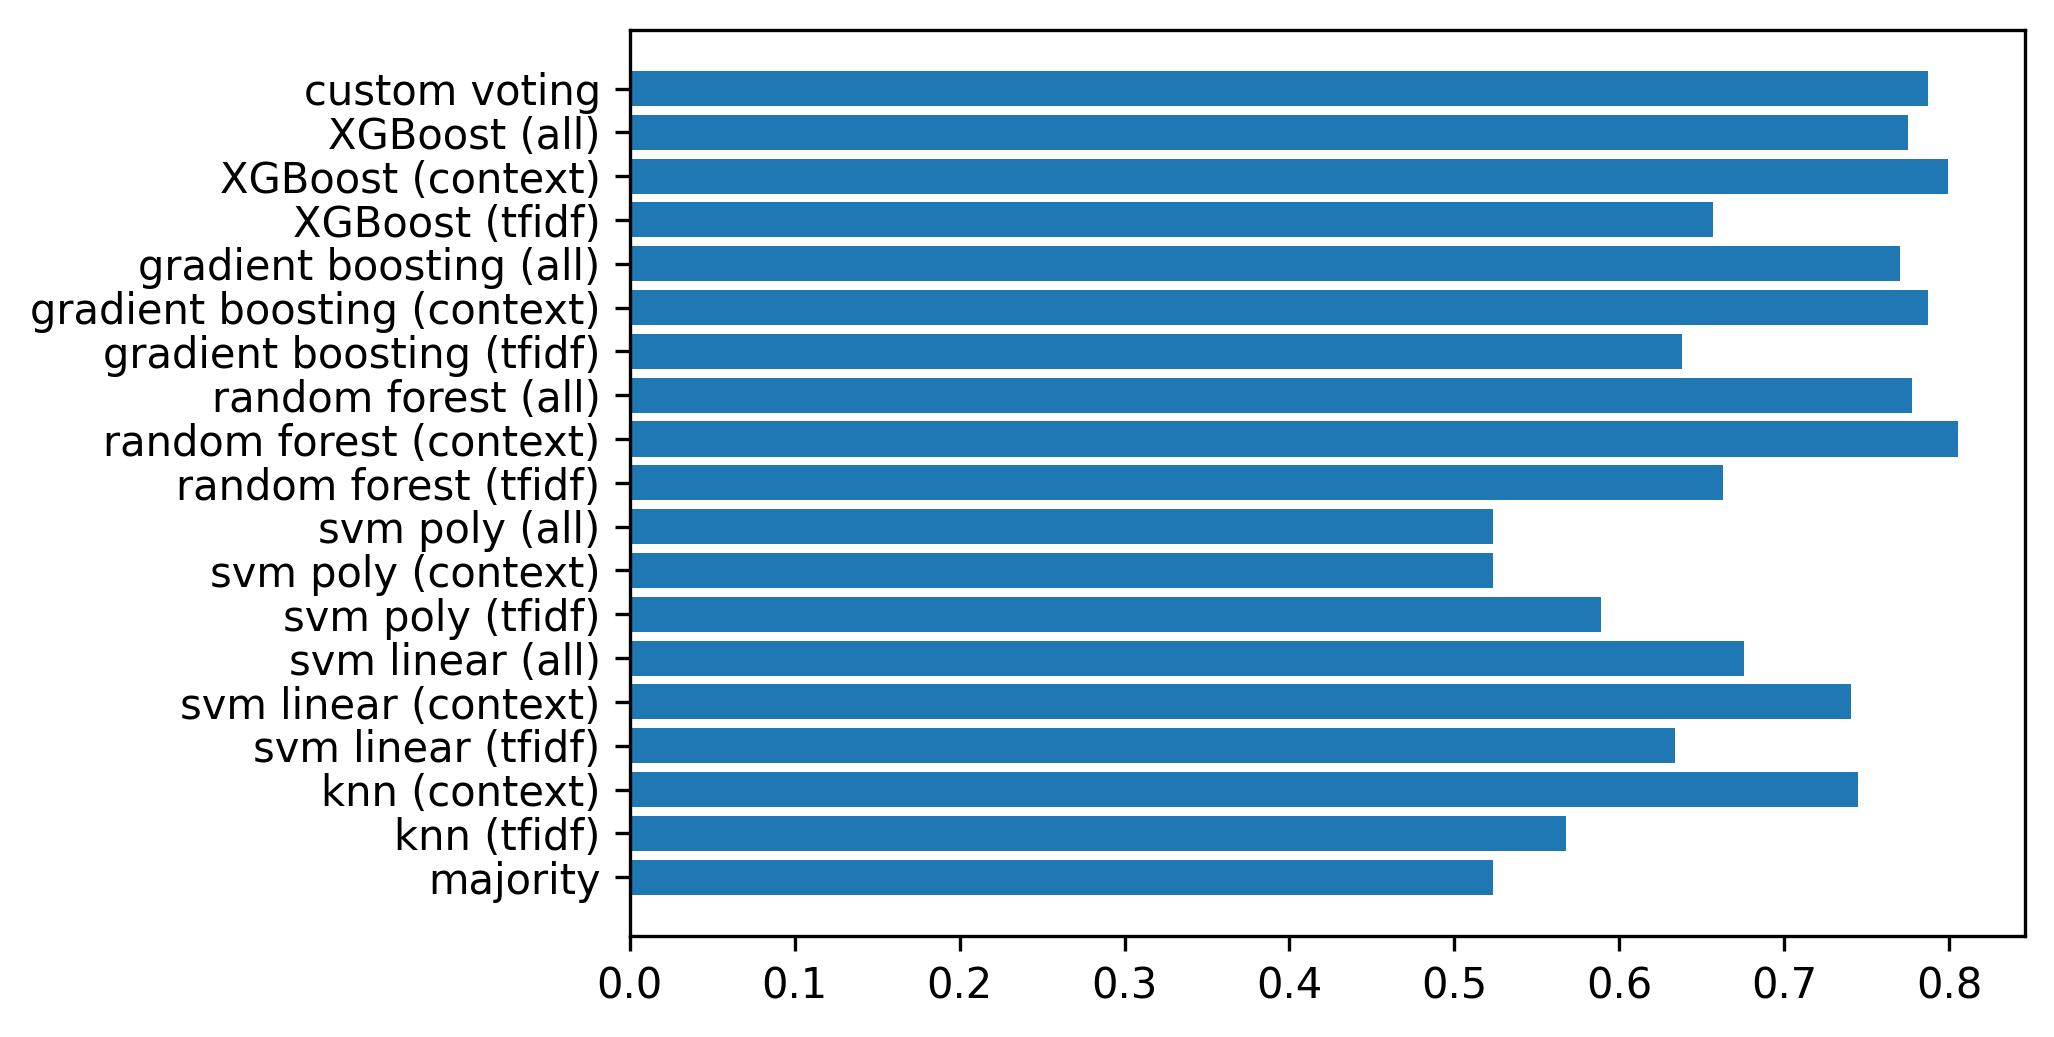

In [8]:
classifier_names = [
    'majority',
    
    'knn (tfidf)',
    'knn (context)',

    'svm linear (tfidf)',
    'svm linear (context)',
    'svm linear (all)',
    
    'svm poly (tfidf)',
    'svm poly (context)',
    'svm poly (all)',
    
    'random forest (tfidf)',
    'random forest (context)',
    'random forest (all)',
    
    'gradient boosting (tfidf)',
    'gradient boosting (context)',
    'gradient boosting (all)',
    
    'XGBoost (tfidf)',
    'XGBoost (context)',
    'XGBoost (all)',
    
    'custom voting',
]
plt.barh(classifier_names, scores)

All the models beat or at least match the majorify classifier. By far the best performers seem to be:

1. Random forest classifier using conextual data and
2. XGBoost classifier using contextual data.

Furhter analisys will focus on the former as it performs slightly better. Let's look at the feature importance.


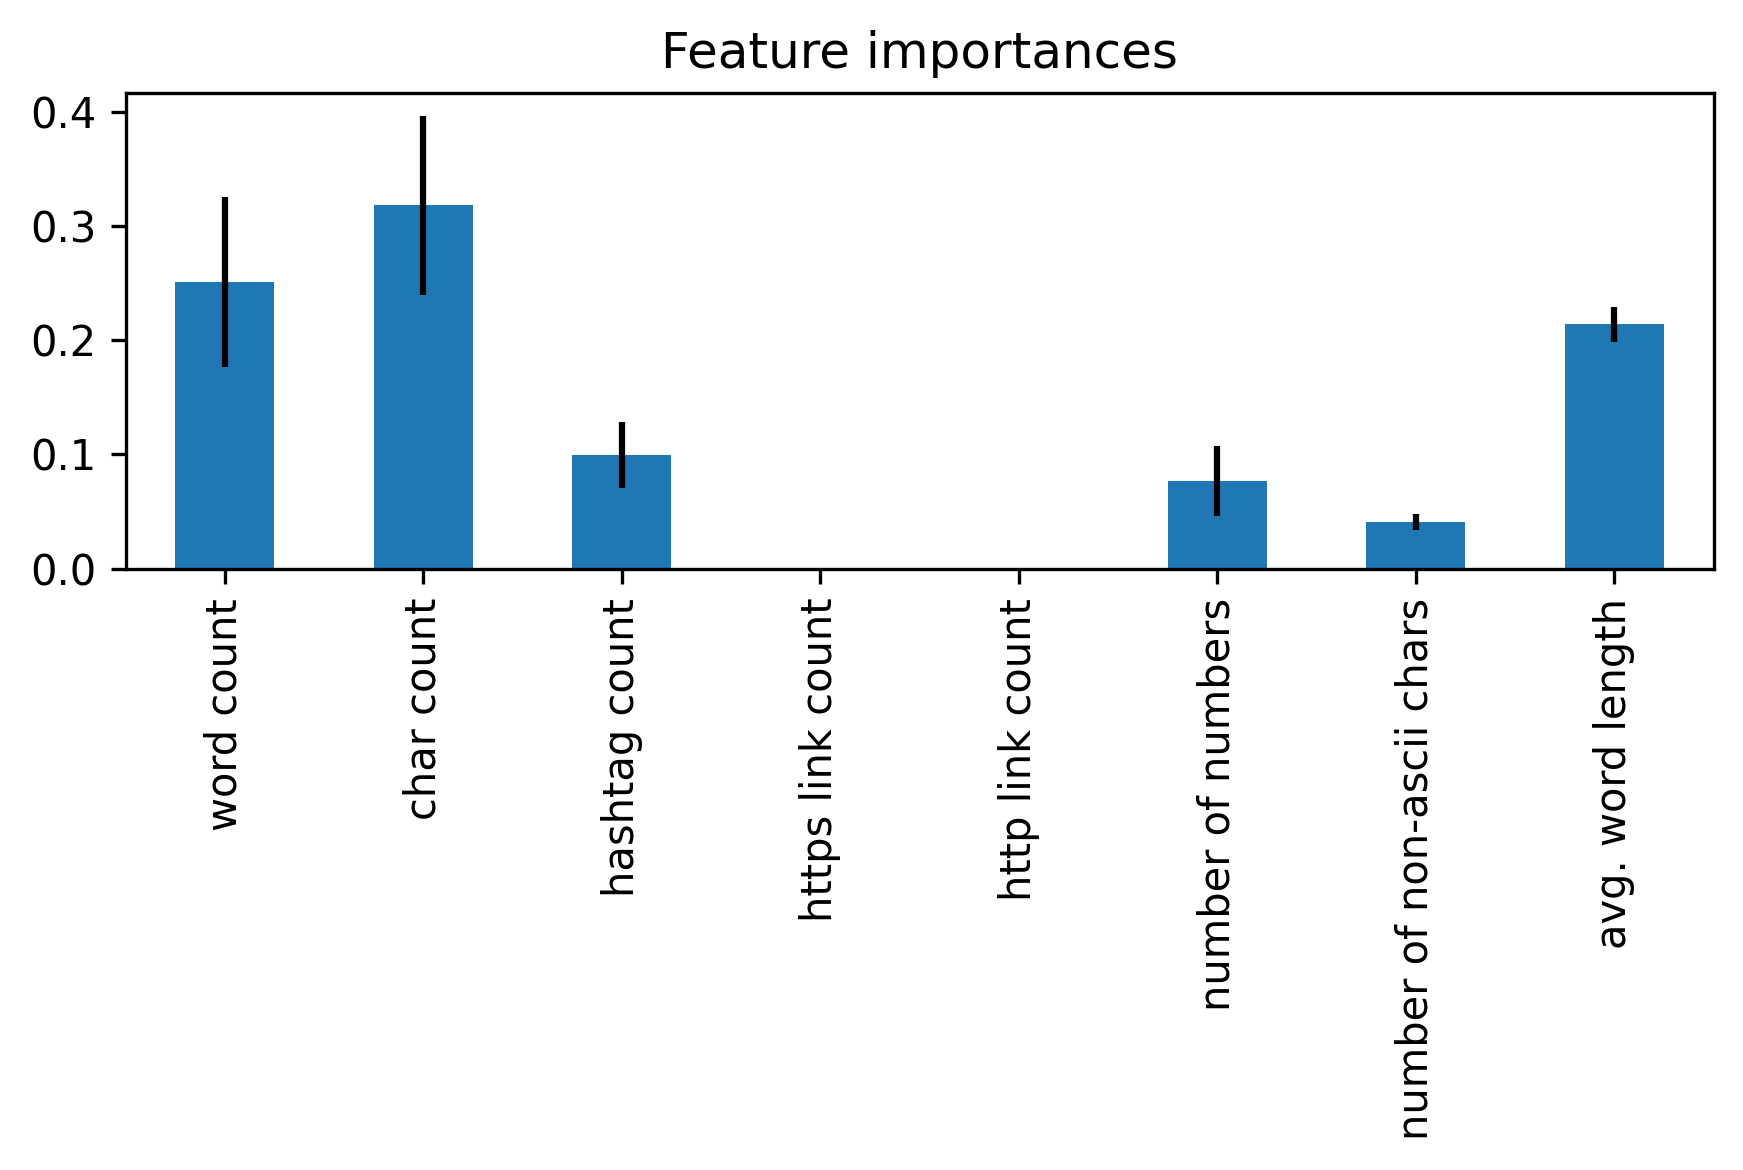

In [9]:

feature_names = [
    'word count',
    'char count',
    'hashtag count',
    'https link count',
    'http link count',
    'number of numbers',
    'number of non-ascii chars',
    'avg. word length',
]

forest_importances = pd.Series(rf_classifier_context.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf_classifier_context.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

The two redundant features are http and https link counts.

All of the other features contribute significantly. Both word and char counts are very important, but have a huge variance as well.

On the other hand, presence of non ASCII chars and average word legth strongly indicate the target class.

One possible explanation could be:

1. That longer words indicate more scienfitic/credible data sources.
2. Longer articles are more credible.
3. Non-ASCII characters indicate non-reliable sources.

However, this data is not easily extracted from a random forest. Therefore, this hypothesis cannot be evaluated.

The accuracy of `0.806` and F1 score of `0.817` place this model way above the majorify classifier. However, this is still considerably below the `char + LR` baseline from the report instructions.